<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Program_Denoising_Autoencoder_dengan_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Pengenalan Denoising Autoencoder**

## Apa itu Denoising Autoencoder?

**Denoising Autoencoder** adalah jenis autoencoder yang dilatih untuk menghilangkan noise dari data [web:9][web:20]. Berbeda dengan autoencoder biasa yang hanya merekonstruksi input, denoising autoencoder menerima input yang telah ditambahkan noise dan mencoba merekonstruksi versi bersih dari input tersebut [web:23].

## Arsitektur

Autoencoder terdiri dari dua bagian utama:
- **Encoder**: Mengkompresi gambar menjadi representasi laten (latent representation) yang lebih kecil
- **Decoder**: Merekonstruksi gambar asli dari representasi laten

## Dataset Fashion MNIST

Fashion MNIST adalah dataset yang berisi 70.000 gambar grayscale berukuran 28×28 pixel dari 10 kategori pakaian yang berbeda [web:11]:
- Training set: 60.000 gambar
- Test set: 10.000 gambar
- Kategori: T-shirt, Celana, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot


In [1]:
# ============================================================================
# 2. IMPORT LIBRARY
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print("Library berhasil diimport!")
print(f"Keras version: {keras.__version__}")

Library berhasil diimport!
Keras version: 3.10.0


# **2. Memuat dan Mempersiapkan Data**

Pada bagian ini, kita akan:
1. Memuat dataset Fashion MNIST
2. Normalisasi data (mengubah nilai pixel dari 0-255 menjadi 0-1)
3. Menambahkan dimensi channel untuk kompatibilitas dengan Conv2D

In [2]:
# ============================================================================
# 3. MEMUAT DAN MEMPERSIAPKAN DATA
# ============================================================================

# Memuat dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(f"Ukuran data training: {x_train.shape}")
print(f"Ukuran data testing: {x_test.shape}")
print(f"Nilai pixel min: {x_train.min()}, max: {x_train.max()}")

# Normalisasi data ke rentang [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape data untuk Conv2D (tambahkan channel dimension)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"\nSetelah preprocessing:")
print(f"Shape training: {x_train.shape}")
print(f"Shape testing: {x_test.shape}")

# Label kategori Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Ukuran data training: (60000, 28, 28)
Ukuran data testing: (10000, 28, 28)
Nilai pixel min: 0, max: 255

Setelah preprocessing:
Shape training: (60000, 28, 28, 1)
Shape testing: (10000, 28, 28, 1)


# **3. Menambahkan Noise pada Data**

Kita akan menambahkan **Gaussian noise** pada gambar [web:23][web:25]. Gaussian noise adalah noise acak yang mengikuti distribusi normal. Ini mensimulasikan kondisi real-world dimana gambar mungkin terganggu oleh noise sensor atau gangguan transmisi.

In [3]:
# ============================================================================
# 4. MENAMBAHKAN NOISE (DERAU) PADA DATA
# ============================================================================

def add_noise(data, noise_factor=0.5):
    """
    Menambahkan Gaussian noise pada data

    Parameters:
    - data: array gambar
    - noise_factor: tingkat noise (semakin besar, semakin berisik)

    Returns:
    - noisy_data: data yang sudah ditambahkan noise
    """
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    # Clip nilai agar tetap dalam rentang [0, 1]
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

# Tambahkan noise pada data training dan testing
noise_factor = 0.5  # Anda bisa eksperimen dengan nilai ini (0.3 - 0.7)
x_train_noisy = add_noise(x_train, noise_factor)
x_test_noisy = add_noise(x_test, noise_factor)

print(f"Noise berhasil ditambahkan dengan noise_factor = {noise_factor}")

Noise berhasil ditambahkan dengan noise_factor = 0.5


# **4. Visualisasi Data Asli vs Data Noisy**

Mari kita lihat perbedaan antara gambar asli dan gambar yang telah ditambahkan noise.

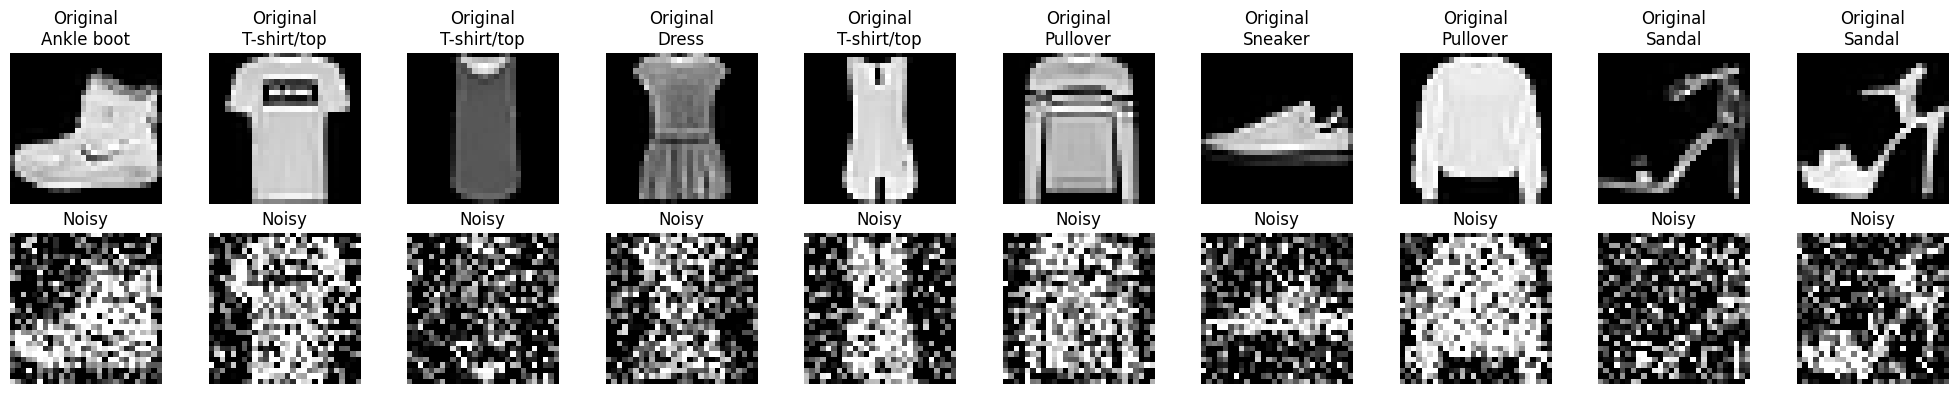

In [4]:
# ============================================================================
# 5. VISUALISASI DATA ASLI VS NOISY
# ============================================================================

def plot_comparison(original, noisy, n=10):
    """
    Menampilkan perbandingan gambar asli dan noisy
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Gambar asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title(f"Original\n{class_names[y_train[i]]}")
        plt.axis('off')

        # Gambar noisy
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Tampilkan 10 sampel
plot_comparison(x_train, x_train_noisy, n=10)

# **5. Membangun Model Denoising Autoencoder**

Kita akan membangun **Convolutional Autoencoder** yang terdiri dari [web:9][web:23]:

## Encoder (Compressor)
- **Conv2D layers**: Mengekstrak fitur penting dari gambar
- **LeakyReLU**: Fungsi aktivasi yang membantu pembelajaran
- **MaxPooling2D**: Mengurangi dimensi spatial (downsampling)

## Decoder (Reconstructor)
- **Conv2D layers**: Memproses fitur
- **UpSampling2D**: Mengembalikan dimensi spatial (upsampling)
- **Sigmoid activation**: Menghasilkan output dalam rentang [0, 1]

In [5]:
# ============================================================================
# 6. MEMBANGUN MODEL DENOISING AUTOENCODER
# ============================================================================

def build_denoising_autoencoder(input_shape=(28, 28, 1)):
    """
    Membangun arsitektur Convolutional Denoising Autoencoder
    """
    # INPUT LAYER
    input_img = layers.Input(shape=input_shape)

    # ========== ENCODER ==========
    # Block 1: Conv + Activation + Pooling
    x = layers.Conv2D(32, (3, 3), padding='same')(input_img)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 28x28 -> 14x14

    # Block 2: Conv + Activation + Pooling
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 14x14 -> 7x7

    # ========== DECODER ==========
    # Block 3: Conv + Activation + Upsampling
    x = layers.Conv2D(64, (3, 3), padding='same')(encoded)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling2D((2, 2))(x)  # 7x7 -> 14x14

    # Block 4: Conv + Activation + Upsampling
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling2D((2, 2))(x)  # 14x14 -> 28x28

    # OUTPUT LAYER
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Membuat model
    autoencoder = models.Model(input_img, decoded, name='Denoising_Autoencoder')

    return autoencoder

# Build model
model = build_denoising_autoencoder()

# Tampilkan arsitektur model
model.summary()

Model: "Denoising_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

# **6. Kompilasi dan Training Model**

Kita akan menggunakan:
- **Loss function**: Mean Squared Error (MSE) - mengukur perbedaan antara gambar asli dan hasil rekonstruksi
- **Optimizer**: Adam - algoritma optimisasi yang efisien
- **Early Stopping**: Menghentikan training jika tidak ada peningkatan untuk menghindari overfitting

In [6]:
# ============================================================================
# 7. KOMPILASI MODEL
# ============================================================================

model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error sebagai metrik tambahan
)

print("Model berhasil dikompilasi!")

Model berhasil dikompilasi!


In [7]:
# ============================================================================
# 8. TRAINING MODEL
# ============================================================================

# Callback untuk early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Training model
# Input: gambar noisy, Target: gambar asli (bersih)
print("Memulai training...")
history = model.fit(
    x_train_noisy,  # Input: gambar dengan noise
    x_train,         # Target: gambar asli tanpa noise
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining selesai!")

Memulai training...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0406 - mae: 0.1329 - val_loss: 0.0202 - val_mae: 0.0806
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0188 - mae: 0.0783 - val_loss: 0.0175 - val_mae: 0.0745
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0171 - mae: 0.0737 - val_loss: 0.0166 - val_mae: 0.0717
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0162 - mae: 0.0714 - val_loss: 0.0160 - val_mae: 0.0717
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0158 - mae: 0.0701 - val_loss: 0.0155 - val_mae: 0.0700
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0154 - mae: 0.0692 - val_loss: 0.0152 - val_mae: 0.0678
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0151 - mae: 0.0681 - val_loss: 0.0151 - val_mae: 0.0686
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0149 - mae: 0.0677 - val_loss: 0.0148 - val_mae: 0.0673
Epoch 9/20
469/469 ━━━━━━━━━━━━━━

# **7. Visualisasi Learning Curves**

Learning curves membantu kita memahami proses pembelajaran model:
- **Training loss menurun**: Model belajar dengan baik
- **Validation loss stabil**: Model tidak overfitting

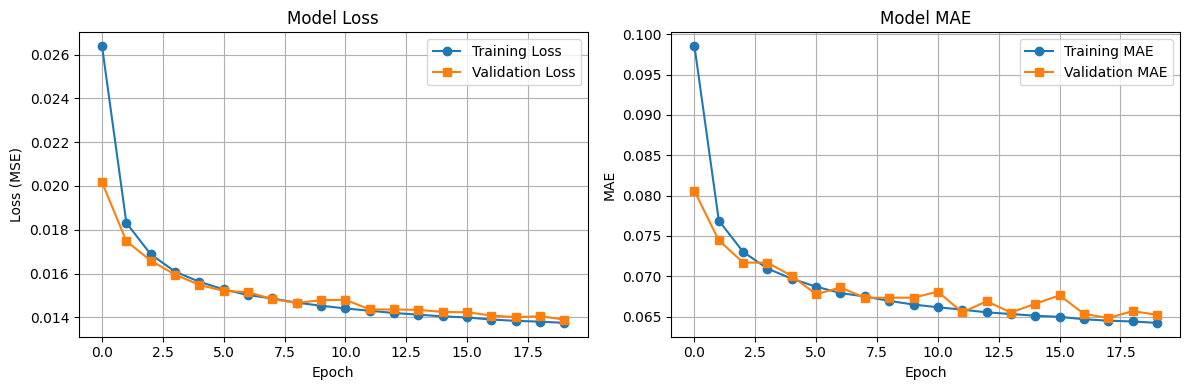

In [8]:
# ============================================================================
# 9. VISUALISASI LEARNING CURVES
# ============================================================================

def plot_learning_curves(history):
    """
    Visualisasi training dan validation loss
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', marker='o')
    plt.plot(history.history['val_mae'], label='Validation MAE', marker='s')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

# **8. Evaluasi Model pada Data Test**

Sekarang kita akan melihat seberapa baik model membersihkan noise dari gambar test.

In [9]:
# ============================================================================
# 10. PREDIKSI DAN EVALUASI
# ============================================================================

# Prediksi pada data test
x_test_denoised = model.predict(x_test_noisy, verbose=0)

# Hitung performa
test_loss, test_mae = model.evaluate(x_test_noisy, x_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.0139
Test MAE: 0.0652


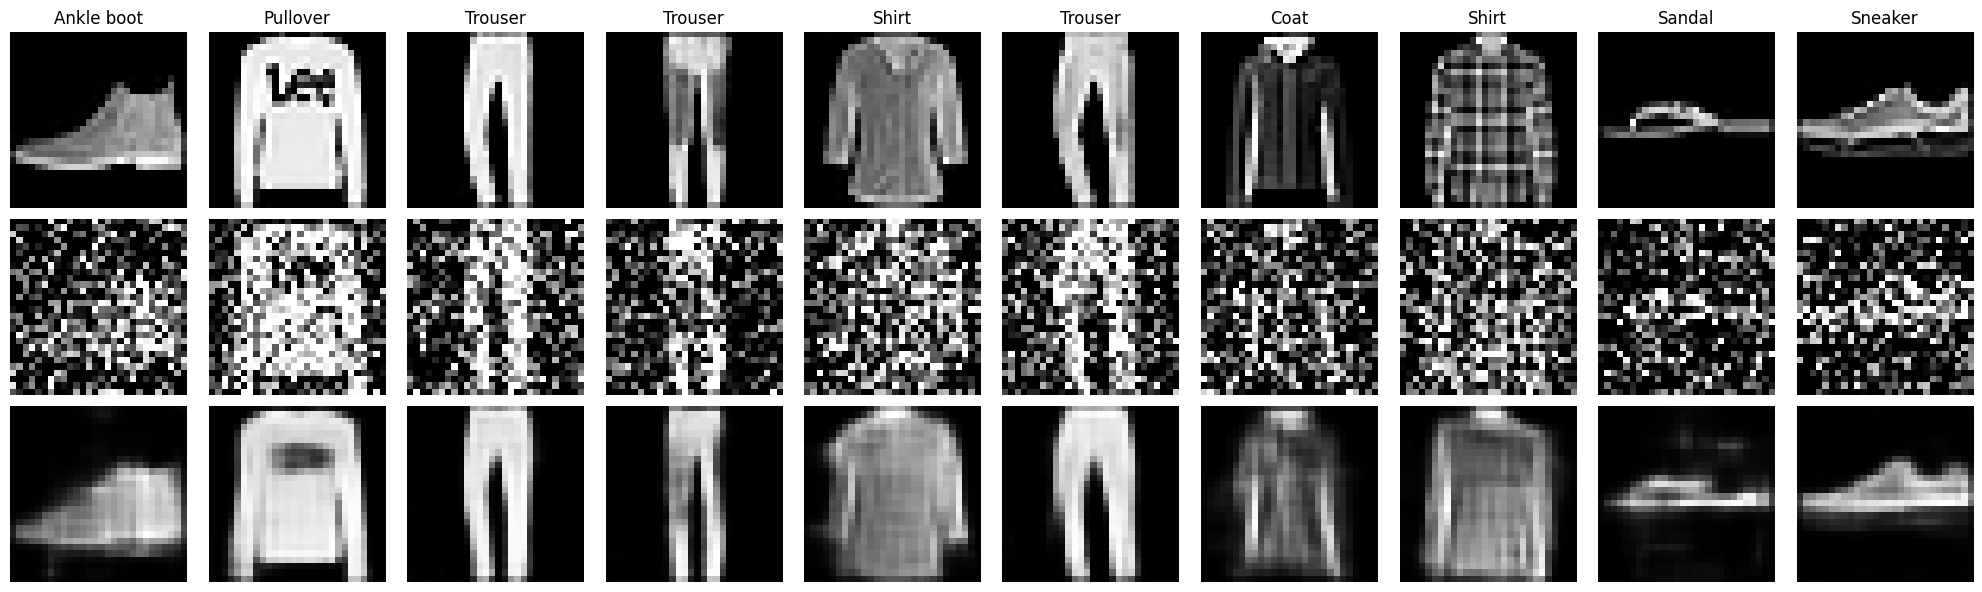

In [10]:
# ============================================================================
# 11. VISUALISASI HASIL DENOISING
# ============================================================================

def plot_denoising_results(original, noisy, denoised, n=10):
    """
    Menampilkan perbandingan: Asli - Noisy - Hasil Denoising
    """
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Gambar asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.ylabel('Original', fontsize=12, fontweight='bold')
        plt.title(class_names[y_test[i]])
        plt.axis('off')

        # Gambar noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.ylabel('Noisy', fontsize=12, fontweight='bold')
        plt.axis('off')

        # Gambar hasil denoising
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.ylabel('Denoised', fontsize=12, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Tampilkan hasil
plot_denoising_results(x_test, x_test_noisy, x_test_denoised, n=10)

# **9. Penerapan pada Data Baru**

Bagian ini mendemonstrasikan cara menggunakan model yang sudah dilatih untuk membersihkan gambar baru yang memiliki noise.

## Skenario Praktis:
- Gambar dari kamera berkualitas rendah
- Gambar yang rusak karena transmisi
- Preprocessing untuk meningkatkan akurasi klasifikasi

CONTOH PENERAPAN PADA DATA BARU


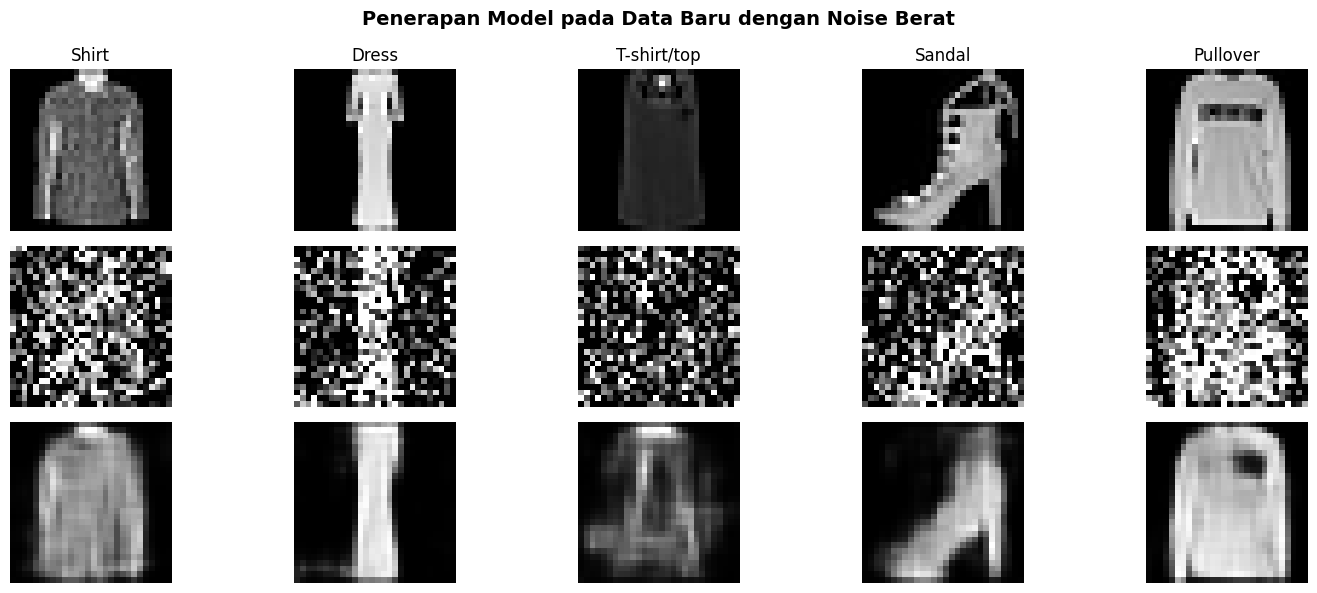


Berhasil memproses 5 gambar baru!


In [11]:
# ============================================================================
# 12. PENERAPAN PADA DATA BARU
# ============================================================================

def denoise_new_image(model, image):
    """
    Fungsi untuk membersihkan noise dari gambar baru

    Parameters:
    - model: model denoising autoencoder yang sudah dilatih
    - image: gambar input (dapat berupa array atau path file)

    Returns:
    - denoised_image: gambar yang sudah dibersihkan
    """
    # Pastikan image dalam format yang benar
    if len(image.shape) == 2:  # Jika grayscale 2D
        image = np.expand_dims(image, axis=-1)

    # Tambahkan batch dimension
    image = np.expand_dims(image, axis=0)

    # Prediksi
    denoised = model.predict(image, verbose=0)

    return denoised[0]

# ============================================================================
# CONTOH 1: Mengambil gambar baru dari test set
# ============================================================================
print("=" * 60)
print("CONTOH PENERAPAN PADA DATA BARU")
print("=" * 60)

# Pilih beberapa gambar secara acak
np.random.seed(42)
random_indices = np.random.choice(len(x_test), 5, replace=False)

# Ambil gambar dan tambahkan noise
new_images = x_test[random_indices]
new_images_noisy = add_noise(new_images, noise_factor=0.6)  # Noise lebih besar

# Proses denoising
denoised_results = []
for img_noisy in new_images_noisy:
    denoised_img = denoise_new_image(model, img_noisy)
    denoised_results.append(denoised_img)

denoised_results = np.array(denoised_results)

# Visualisasi
plt.figure(figsize=(15, 6))
for i in range(5):
    # Original
    plt.subplot(3, 5, i + 1)
    plt.imshow(new_images[i].reshape(28, 28), cmap='gray')
    if i == 0:
        plt.ylabel('Original', fontsize=10, fontweight='bold')
    plt.title(class_names[y_test[random_indices[i]]])
    plt.axis('off')

    # Noisy (noise factor = 0.6)
    plt.subplot(3, 5, i + 6)
    plt.imshow(new_images_noisy[i].reshape(28, 28), cmap='gray')
    if i == 0:
        plt.ylabel('Heavy Noise', fontsize=10, fontweight='bold')
    plt.axis('off')

    # Denoised
    plt.subplot(3, 5, i + 11)
    plt.imshow(denoised_results[i].reshape(28, 28), cmap='gray')
    if i == 0:
        plt.ylabel('Denoised', fontsize=10, fontweight='bold')
    plt.axis('off')

plt.suptitle('Penerapan Model pada Data Baru dengan Noise Berat', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nBerhasil memproses {len(random_indices)} gambar baru!")

In [12]:
# ============================================================================
# 13. FUNGSI UTILITY UNTUK PENGGUNAAN PRAKTIS
# ============================================================================

def batch_denoise(model, noisy_images):
    """
    Membersihkan noise dari batch gambar sekaligus

    Parameters:
    - model: model yang sudah dilatih
    - noisy_images: array gambar noisy (batch)

    Returns:
    - denoised_images: array gambar yang sudah dibersihkan
    """
    # Pastikan format yang benar
    if len(noisy_images.shape) == 3:
        noisy_images = np.expand_dims(noisy_images, axis=-1)

    # Prediksi batch
    denoised = model.predict(noisy_images, verbose=0)

    return denoised

# Contoh penggunaan batch processing
print("\n" + "=" * 60)
print("BATCH PROCESSING")
print("=" * 60)

# Ambil 20 gambar
batch_size = 20
batch_noisy = x_test_noisy[:batch_size]
batch_original = x_test[:batch_size]

# Proses batch
batch_denoised = batch_denoise(model, batch_noisy)

# Hitung improvement
mse_before = np.mean((batch_noisy - batch_original) ** 2)
mse_after = np.mean((batch_denoised - batch_original) ** 2)
improvement = ((mse_before - mse_after) / mse_before) * 100

print(f"MSE sebelum denoising: {mse_before:.4f}")
print(f"MSE setelah denoising: {mse_after:.4f}")
print(f"Improvement: {improvement:.2f}%")


BATCH PROCESSING
MSE sebelum denoising: 0.1154
MSE setelah denoising: 0.0139
Improvement: 87.93%


In [13]:
# ============================================================================
# 14. MENYIMPAN MODEL
# ============================================================================

# Simpan model
model_path = 'denoising_autoencoder_fashion_mnist.h5'
model.save(model_path)
print(f"Model berhasil disimpan di: {model_path}")

# Untuk memuat model kembali:
# loaded_model = keras.models.load_model(model_path)
# print("Model berhasil dimuat!")

Model berhasil disimpan di: denoising_autoencoder_fashion_mnist.h5


# **11. Kesimpulan dan Analisis**

## Hasil yang Dicapai:
1. Model berhasil menghilangkan noise dari gambar Fashion MNIST [web:20][web:24]
2. Gambar hasil denoising mempertahankan fitur penting dari gambar asli
3. Model dapat diterapkan pada data baru dengan berbagai tingkat noise

## Kelebihan Denoising Autoencoder:
- Otomatis belajar fitur penting tanpa feature engineering manual
- Dapat menangani berbagai jenis dan tingkat noise
- Generalisasi baik pada data baru

## Limitasi:
- Performa bergantung pada tingkat noise saat training [web:9]
- Mungkin kehilangan detail halus pada gambar
- Memerlukan data training yang cukup banyak

## Aplikasi Praktis:
- Preprocessing untuk image classification
- Restorasi foto lama atau rusak
- Peningkatan kualitas gambar medis
- Pengolahan citra satelit

## Eksperimen Lanjutan:
1. Coba variasikan arsitektur (tambah layer, ubah filter size)
2. Eksperimen dengan noise_factor berbeda
3. Gunakan jenis noise lain (Salt & Pepper, Poisson)
4. Implementasikan Variational Autoencoder (VAE)
5. Coba dataset lain (CIFAR-10, custom images)


In [14]:
# ============================================================================
# 15. METRIK EVALUASI TAMBAHAN
# ============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(original, noisy, denoised):
    """
    Menghitung berbagai metrik evaluasi
    """
    # Flatten untuk perhitungan
    original_flat = original.flatten()
    noisy_flat = noisy.flatten()
    denoised_flat = denoised.flatten()

    # MSE
    mse_noisy = mean_squared_error(original_flat, noisy_flat)
    mse_denoised = mean_squared_error(original_flat, denoised_flat)

    # MAE
    mae_noisy = mean_absolute_error(original_flat, noisy_flat)
    mae_denoised = mean_absolute_error(original_flat, denoised_flat)

    # PSNR (Peak Signal-to-Noise Ratio)
    psnr_noisy = 10 * np.log10(1.0 / mse_noisy)
    psnr_denoised = 10 * np.log10(1.0 / mse_denoised)

    return {
        'MSE_noisy': mse_noisy,
        'MSE_denoised': mse_denoised,
        'MAE_noisy': mae_noisy,
        'MAE_denoised': mae_denoised,
        'PSNR_noisy': psnr_noisy,
        'PSNR_denoised': psnr_denoised
    }

# Hitung metrik untuk seluruh test set
metrics = calculate_metrics(x_test, x_test_noisy, x_test_denoised)

print("\n" + "=" * 60)
print("METRIK EVALUASI LENGKAP")
print("=" * 60)
print(f"Mean Squared Error:")
print(f"  - Gambar Noisy    : {metrics['MSE_noisy']:.6f}")
print(f"  - Gambar Denoised : {metrics['MSE_denoised']:.6f}")
print(f"  - Improvement     : {((metrics['MSE_noisy']-metrics['MSE_denoised'])/metrics['MSE_noisy']*100):.2f}%")
print()
print(f"Mean Absolute Error:")
print(f"  - Gambar Noisy    : {metrics['MAE_noisy']:.6f}")
print(f"  - Gambar Denoised : {metrics['MAE_denoised']:.6f}")
print(f"  - Improvement     : {((metrics['MAE_noisy']-metrics['MAE_denoised'])/metrics['MAE_noisy']*100):.2f}%")
print()
print(f"PSNR (semakin tinggi semakin baik):")
print(f"  - Gambar Noisy    : {metrics['PSNR_noisy']:.2f} dB")
print(f"  - Gambar Denoised : {metrics['PSNR_denoised']:.2f} dB")
print(f"  - Improvement     : {(metrics['PSNR_denoised']-metrics['PSNR_noisy']):.2f} dB")
print("=" * 60)



METRIK EVALUASI LENGKAP
Mean Squared Error:
  - Gambar Noisy    : 0.117699
  - Gambar Denoised : 0.013896
  - Improvement     : 88.19%

Mean Absolute Error:
  - Gambar Noisy    : 0.233826
  - Gambar Denoised : 0.065236
  - Improvement     : 72.10%

PSNR (semakin tinggi semakin baik):
  - Gambar Noisy    : 9.29 dB
  - Gambar Denoised : 18.57 dB
  - Improvement     : 9.28 dB


---

## Referensi dan Bacaan Lanjutan

1. Vincent, P., et al. (2008). "Extracting and Composing Robust Features with Denoising Autoencoders"
2. Keras Documentation: https://keras.io/examples/vision/autoencoder/
3. Fashion MNIST Dataset: https://github.com/zalandoresearch/fashion-mnist
4. Convolutional Autoencoders untuk Image Denoising

---

**Catatan untuk Mahasiswa:**
- Eksperimen dengan hyperparameter untuk memahami pengaruhnya
- Coba visualisasi representasi laten di tengah autoencoder
- Bandingkan dengan metode denoising tradisional (Gaussian filter, Median filter)
- Dokumentasikan hasil eksperimen Anda

**Tugas Mandiri:**
1. Modifikasi arsitektur dengan menambah/mengurangi layer
2. Implementasikan untuk dataset MNIST atau CIFAR-10
3. Buat fungsi untuk menambahkan jenis noise lain (salt & pepper)
4. Bandingkan hasil dengan menggunakan optimizer berbeda

---

**Selamat Belajar! 🚀**
